  **Model Pruning**

 ---> Pruning is a technique of reducing Model size for making it memory efficient without loosing the accuracy       of the actual model.
 
 ---> Pruning is required as models are getting very large , they becomes a problem while deploying process.
 
 ---> I have performed some approaches for pruning my model and compared their results on the basis of 
        Accuracy , 
        Size of the model without Zipping it ,
        Size of the model after zipping and 
        Time taken evaluation(Inference time).

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import os
import time
from datetime import datetime
import zipfile

tf.__version__

'2.2.0'

In [2]:
#Cifar10 Dataset

data = keras.datasets.cifar10

In [3]:
(train_images, train_labels), (test_images, test_labels) = data.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
#normalizing images

train_images = train_images/255.0
test_images = test_images/255.0

In [5]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

In [6]:
#converting rgb images to grayscale images to reduce processing time.

def gray_img(images):
    images_grayscale = np.zeros(images.shape[:-1])
    for i in range(0,images.shape[0]):
        images_grayscale[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
        
    return images_grayscale

In [7]:
train_images = gray_img(train_images)
test_images = gray_img(test_images)

In [8]:
train_images.shape

(50000, 32, 32)

# Base Model for Cifar-10 Dataset

In [9]:
# CNN model

model = keras.Sequential()
model.add(keras.Input(shape = (32,32)))
model.add(keras.layers.Reshape(target_shape = (32,32,1)))
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0

In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.fit(
  train_images,
  train_labels,
  epochs=8,
  validation_split=0.1,
)

Epoch 1/8
1407/1407 [==============================] - 34s 24ms/step - loss: 1.6656 - accuracy: 0.3941 - val_loss: 1.3141 - val_accuracy: 0.5278
Epoch 2/8
1407/1407 [==============================] - 33s 24ms/step - loss: 1.2379 - accuracy: 0.5632 - val_loss: 1.1086 - val_accuracy: 0.5996
Epoch 3/8
1407/1407 [==============================] - 33s 24ms/step - loss: 1.0510 - accuracy: 0.6304 - val_loss: 1.0212 - val_accuracy: 0.6420
Epoch 4/8
1407/1407 [==============================] - 33s 23ms/step - loss: 0.9220 - accuracy: 0.6776 - val_loss: 0.9321 - val_accuracy: 0.6738
Epoch 5/8
1407/1407 [==============================] - 34s 24ms/step - loss: 0.8302 - accuracy: 0.7121 - val_loss: 0.9556 - val_accuracy: 0.6670
Epoch 6/8
1407/1407 [==============================] - 33s 23ms/step - loss: 0.7549 - accuracy: 0.7336 - val_loss: 0.9077 - val_accuracy: 0.6906
Epoch 7/8
1407/1407 [==============================] - 33s 24ms/step - loss: 0.6855 - accuracy: 0.7599 - val_loss: 0.9215 - val_ac

In [12]:
def factors(model , model_name , zip_name):
    start = datetime.now()
    _, model_accuracy = model.evaluate(
        test_images, test_labels, verbose=0)
    end = datetime.now()
    
    t = end-start
    
    model.save(model_name)
    
    size_without_zip = os.path.getsize(model_name)
    
    size_with_zip = get_gzipped_model_size(model_name , zip_name)
    
    return t.total_seconds() , model_accuracy, size_without_zip , size_with_zip

In [13]:
def get_gzipped_model_size(file , zip_name):
    with zipfile.ZipFile(zip_name, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
        
    return os.path.getsize(zip_name)

In [14]:
time_1  , accuracy_1 ,size_without_zip_1 ,size_with_zip_1 = factors(model , 'Base Model.h5' ,'Base Model.zip')

name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')

Accuracy of basemodel is :68.22 %
Size of basemodel without Zip is : 3160952 Bytes
Size of basemodel with Zip is : 2449479 Bytes
Time taken for evaluating basemodel is : 2.190858 sec


# Method - 1) Using Tensorflow model optimization Kit for model pruning and compressing

 ==> Model is pruned and stripped for compressing the size of the model.(Results are shown in the notebook)
 
 ==> First approach - Pruning the whole network model to 80% Sparsity.
 
 ==> Second approach - Pruning only Dense layers of the Network Model.

In [15]:
# tensorflow model optimization kit

!pip install -q tensorflow-model-optimization

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [16]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# (A) Pruning Whole network with 80% sparsity

In [17]:
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs
# Define model for pruning.

model_without_pruning = keras.models.load_model('Base Model.h5')
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model_without_pruning,**pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_reshape  (None, 32, 32, 1)         1         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 30, 30, 32)        610       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 15, 15, 32)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 13, 13, 64)        36930     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 6, 6, 64)          1         
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 4, 4, 128)         147586    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 2, 2, 128)         1

In [18]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]
  
model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2
352/352 [==============================] - 27s 78ms/step - loss: 1.8152 - accuracy: 0.6589 - val_loss: 1.8174 - val_accuracy: 0.6482
Epoch 2/2
352/352 [==============================] - 28s 79ms/step - loss: 1.7768 - accuracy: 0.6988 - val_loss: 1.7846 - val_accuracy: 0.6850


In [19]:
time_2  , accuracy_2 ,size_without_zip_2 ,size_with_zip_2 = factors(model_for_pruning , 'Model Pruned.h5' ,'Model Pruned.zip')

In [20]:
name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')
print('\n')

name = 'pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_2*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_2 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_2 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_2, 'sec')
print('\n')

Accuracy of basemodel is :68.22 %
Size of basemodel without Zip is : 3160952 Bytes
Size of basemodel with Zip is : 2449479 Bytes
Time taken for evaluating basemodel is : 2.190858 sec


Accuracy of pruned model is :67.49 %
Size of pruned model without Zip is : 4220968 Bytes
Size of pruned model with Zip is : 1462917 Bytes
Time taken for evaluating pruned model is : 2.319753 sec




# Model stripped for compressing Size of model

In [21]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

model_for_export.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
time_3  , accuracy_3 ,size_without_zip_3 ,size_with_zip_3 = factors(model_for_export , 'Model stripped.h5' ,'Model Stripped.zip')

In [23]:
name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')
print('\n')

name = 'pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_2*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_2 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_2 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_2, 'sec')
print('\n')

name = 'striped model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_3*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_3 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_3 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_3, 'sec')
print('\n')

Accuracy of basemodel is :68.22 %
Size of basemodel without Zip is : 3160952 Bytes
Size of basemodel with Zip is : 2449479 Bytes
Time taken for evaluating basemodel is : 2.190858 sec


Accuracy of pruned model is :67.49 %
Size of pruned model without Zip is : 4220968 Bytes
Size of pruned model with Zip is : 1462917 Bytes
Time taken for evaluating pruned model is : 2.319753 sec


Accuracy of striped model is :67.49 %
Size of striped model without Zip is : 1065584 Bytes
Size of striped model with Zip is : 309312 Bytes
Time taken for evaluating striped model is : 2.250886 sec




# (B) Pruning only Dense layers 

In [24]:
def apply_pruning_to_dense(layer):
    if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer , **pruning_params)
    return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense` 
# to the layers of the model.
model_for_dense_layer_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)

model_for_dense_layer_pruning.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0

In [25]:
model_for_dense_layer_pruning.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
time_4  , accuracy_4 ,size_without_zip_4 ,size_with_zip_4 = factors(model_for_dense_layer_pruning , 'Dense layers pruned.h5' ,'Dense layers pruned.zip')

In [27]:
name = 'dense layer pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_4*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_4 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_4 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_4, 'sec')
print('\n')

Accuracy of dense layer pruned model is :68.22 %
Size of dense layer pruned model without Zip is : 1733620 Bytes
Size of dense layer pruned model with Zip is : 966978 Bytes
Time taken for evaluating dense layer pruned model is : 2.249126 sec




In [28]:
name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')
print('\n')

name = 'pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_2*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_2 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_2 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_2, 'sec')
print('\n')

name = 'striped model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_3*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_3 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_3 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_3, 'sec')
print('\n')

name = 'dense layer pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_4*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_4 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_4 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_4, 'sec')
print('\n')

Accuracy of basemodel is :68.22 %
Size of basemodel without Zip is : 3160952 Bytes
Size of basemodel with Zip is : 2449479 Bytes
Time taken for evaluating basemodel is : 2.190858 sec


Accuracy of pruned model is :67.49 %
Size of pruned model without Zip is : 4220968 Bytes
Size of pruned model with Zip is : 1462917 Bytes
Time taken for evaluating pruned model is : 2.319753 sec


Accuracy of striped model is :67.49 %
Size of striped model without Zip is : 1065584 Bytes
Size of striped model with Zip is : 309312 Bytes
Time taken for evaluating striped model is : 2.250886 sec


Accuracy of dense layer pruned model is :68.22 %
Size of dense layer pruned model without Zip is : 1733620 Bytes
Size of dense layer pruned model with Zip is : 966978 Bytes
Time taken for evaluating dense layer pruned model is : 2.249126 sec




# Model stripped to compress the size

In [29]:
model_stripped_pruned_denselayer = tfmot.sparsity.keras.strip_pruning(model_for_dense_layer_pruning)

model_stripped_pruned_denselayer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
time_5  , accuracy_5 ,size_without_zip_5 ,size_with_zip_5 = factors(model_stripped_pruned_denselayer , 'Dense layers pruned and stripped.h5' ,'Dense layers pruned and stripped.zip')

In [31]:
name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')
print('\n')

name = 'pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_2*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_2 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_2 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_2, 'sec')
print('\n')

name = 'striped model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_3*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_3 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_3 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_3, 'sec')
print('\n')

name = 'dense layer pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_4*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_4 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_4 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_4, 'sec')
print('\n')

name = 'dense layer pruned and stripped model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_5*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_5 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_5 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_5, 'sec')
print('\n')

Accuracy of basemodel is :68.22 %
Size of basemodel without Zip is : 3160952 Bytes
Size of basemodel with Zip is : 2449479 Bytes
Time taken for evaluating basemodel is : 2.190858 sec


Accuracy of pruned model is :67.49 %
Size of pruned model without Zip is : 4220968 Bytes
Size of pruned model with Zip is : 1462917 Bytes
Time taken for evaluating pruned model is : 2.319753 sec


Accuracy of striped model is :67.49 %
Size of striped model without Zip is : 1065584 Bytes
Size of striped model with Zip is : 309312 Bytes
Time taken for evaluating striped model is : 2.250886 sec


Accuracy of dense layer pruned model is :68.22 %
Size of dense layer pruned model without Zip is : 1733620 Bytes
Size of dense layer pruned model with Zip is : 966978 Bytes
Time taken for evaluating dense layer pruned model is : 2.249126 sec


Accuracy of dense layer pruned and stripped model is :68.22 %
Size of dense layer pruned and stripped model without Zip is : 1065576 Bytes
Size of dense layer pruned and stri

# Method -2) Pruning by using weight matrix

Rank the weights in weight matrix of every layer according to their Magnitude and setting the lowest n% to Zero. (here i have taken n == 20% ,because we are doing it in every layer and also my model is not that big so it can loose knowledge and accuracy can be lost with higher value)

In [32]:
base = keras.models.load_model("Base Model.h5")

In [33]:
base.weights

[<tf.Variable 'conv2d_7/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-0.18108147, -0.08157163, -0.16430558,  0.22603343,
           -0.10076968,  0.04623508,  0.01708895, -0.25348216,
           -0.02619119, -0.10399739, -0.00315159,  0.1635194 ,
            0.12029513, -0.14936063,  0.09875044,  0.02706814,
            0.0323607 , -0.1135293 , -0.1660668 , -0.16181146,
           -0.1443373 ,  0.10187791, -0.04375806, -0.27222505,
           -0.16120484,  0.00854217, -0.02305365, -0.16785683,
            0.24579178,  0.15908384,  0.0310737 ,  0.18363091]],
 
         [[ 0.13336743, -0.02310973,  0.04904799,  0.22686704,
           -0.01910317,  0.22966391,  0.08271872,  0.19061613,
           -0.00922722, -0.25740632,  0.07358554,  0.16405706,
           -0.16824943,  0.11895399,  0.16319053,  0.15487538,
           -0.16724189,  0.1489278 ,  0.08821333, -0.2512287 ,
            0.1559277 ,  0.03615515, -0.13855718, -0.01179653,
           -0.0602243 , -0.10399408, -

In [34]:
for layer in base.layers:
    print(layer.name)

reshape
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense
dense_1
dense_2


In [35]:
from scipy.stats import rankdata

for k in [.20]:
    ranks = {}
    for l in base.layers:
        data = base.get_layer(l.name).get_weights()
        
        if len(data) == 0:
            continue
        else:
            temp = []
            w = data
            for i in range(0,np.array(data).shape[0]):
                ranks[l]=(rankdata(np.abs(w[i]),method='dense') - 1).astype(int).reshape(w[i].shape)
                lower_bound_rank = np.ceil(np.max(ranks[l])*k).astype(int)
                ranks[l][ranks[l]<=lower_bound_rank] = 0
                ranks[l][ranks[l]>lower_bound_rank] = 1
                w[i] = w[i]*ranks[l]
                temp.append(np.array(w[i]))
            print(temp)
            base.get_layer(l.name).set_weights(np.array(temp))

[array([[[[-0.18108147, -0.08157163, -0.16430558,  0.22603343,
          -0.10076968,  0.04623508,  0.        , -0.25348216,
          -0.        , -0.10399739, -0.        ,  0.1635194 ,
           0.12029513, -0.14936063,  0.09875044,  0.        ,
           0.        , -0.1135293 , -0.1660668 , -0.16181146,
          -0.1443373 ,  0.10187791, -0.04375806, -0.27222505,
          -0.16120484,  0.        , -0.        , -0.16785683,
           0.24579178,  0.15908384,  0.        ,  0.18363091]],

        [[ 0.13336743, -0.        ,  0.04904799,  0.22686704,
          -0.        ,  0.22966391,  0.08271872,  0.19061613,
          -0.        , -0.25740632,  0.07358554,  0.16405706,
          -0.16824943,  0.11895399,  0.16319053,  0.15487538,
          -0.16724189,  0.14892779,  0.08821333, -0.25122869,
           0.1559277 ,  0.03615515, -0.13855718, -0.        ,
          -0.0602243 , -0.10399408, -0.09209093, -0.10050081,
          -0.        , -0.0642534 , -0.18241611,  0.04742631]],

 

In [36]:
base.save("Weight pruned 20%.h5")

In [37]:
new_model = keras.models.load_model("Weight pruned 20%.h5")

In [38]:
new_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time_6  , accuracy_6 ,size_without_zip_6 ,size_with_zip_6 = factors(new_model , 'Weight pruned 20%.h5' ,'Weight pruned 20%.zip')


In [39]:
name = 'weight pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_6*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_6 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_6 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_6, 'sec')
print('\n')

name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')

Accuracy of weight pruned model is :62.01 %
Size of weight pruned model without Zip is : 1065584 Bytes
Size of weight pruned model with Zip is : 833835 Bytes
Time taken for evaluating weight pruned model is : 2.25099 sec


Accuracy of basemodel is :68.22 %
Size of basemodel without Zip is : 3160952 Bytes
Size of basemodel with Zip is : 2449479 Bytes
Time taken for evaluating basemodel is : 2.190858 sec


# method -3) Pruning Neurons 

==> Calculating L2 norm of every column of the weight matrix and replacing smallest n% to Zero. (here i  have gone till n=40% of sparsity )

==> Sparsing should be done in steps otherwise it will damage the model accuracy.

In [40]:
base = keras.models.load_model("Base Model.h5")

In [41]:
base.weights

[<tf.Variable 'conv2d_9/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-0.18108147, -0.08157163, -0.16430558,  0.22603343,
           -0.10076968,  0.04623508,  0.01708895, -0.25348216,
           -0.02619119, -0.10399739, -0.00315159,  0.1635194 ,
            0.12029513, -0.14936063,  0.09875044,  0.02706814,
            0.0323607 , -0.1135293 , -0.1660668 , -0.16181146,
           -0.1443373 ,  0.10187791, -0.04375806, -0.27222505,
           -0.16120484,  0.00854217, -0.02305365, -0.16785683,
            0.24579178,  0.15908384,  0.0310737 ,  0.18363091]],
 
         [[ 0.13336743, -0.02310973,  0.04904799,  0.22686704,
           -0.01910317,  0.22966391,  0.08271872,  0.19061613,
           -0.00922722, -0.25740632,  0.07358554,  0.16405706,
           -0.16824943,  0.11895399,  0.16319053,  0.15487538,
           -0.16724189,  0.1489278 ,  0.08821333, -0.2512287 ,
            0.1559277 ,  0.03615515, -0.13855718, -0.01179653,
           -0.0602243 , -0.10399408, -

In [42]:
from numpy import linalg as LA


for k in [.10 , .20 , .30 , .40]:
    ranks = {}
    for l in base.layers:
        data = base.get_layer(l.name).get_weights()
        
        if len(data) == 0:
            continue
        else:
            temp = []
            w = data
            for i in range(0,np.array(data).shape[0]):
                norm = LA.norm(w[i],axis=0)
                norm = np.tile(norm,(w[i].shape[0],1))
                ranks[l]=(rankdata(norm,method='dense') - 1).astype(int).reshape(norm.shape)
                lower_bound_rank = np.ceil(np.max(ranks[l])*k).astype(int)
                ranks[l][ranks[l]<=lower_bound_rank] = 0
                ranks[l][ranks[l]>lower_bound_rank] = 1
                w[i] = w[i]*ranks[l]
                temp.append(np.array(w[i]))
            print(temp)
            base.get_layer(l.name).set_weights(np.array(temp))

[array([[[[-0.18108147, -0.08157163, -0.16430558,  0.22603343,
          -0.10076968,  0.04623508,  0.01708895, -0.25348216,
          -0.        , -0.10399739, -0.00315159,  0.1635194 ,
           0.12029513, -0.14936063,  0.        ,  0.        ,
           0.0323607 , -0.1135293 , -0.1660668 , -0.16181146,
          -0.1443373 ,  0.10187791, -0.04375806, -0.27222505,
          -0.16120484,  0.        , -0.02305365, -0.16785683,
           0.24579178,  0.15908384,  0.0310737 ,  0.18363091],
         [-0.18108147, -0.08157163, -0.16430558,  0.22603343,
          -0.10076968,  0.04623508,  0.01708895, -0.25348216,
          -0.        , -0.10399739, -0.00315159,  0.1635194 ,
           0.12029513, -0.14936063,  0.        ,  0.        ,
           0.0323607 , -0.1135293 , -0.1660668 , -0.16181146,
          -0.1443373 ,  0.10187791, -0.04375806, -0.27222505,
          -0.16120484,  0.        , -0.02305365, -0.16785683,
           0.24579178,  0.15908384,  0.0310737 ,  0.18363091],
     

ValueError: Layer weight shape (3, 3, 1, 32) not compatible with provided weight shape (3, 3, 3, 32)

In [43]:
base.save("Model neuron pruned 40.h5")

In [44]:
new_model2 = keras.models.load_model("Model neuron pruned 40.h5")

In [45]:
new_model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time_7  , accuracy_7 ,size_without_zip_7 ,size_with_zip_7 = factors(new_model2 , 'Model neuron pruned 40.h5' ,'Model neuron pruned 40.zip')


# Comparing the results

In [46]:
name = 'basemodel'

print('Accuracy of %s is :%.2f' % (name ,accuracy_1*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_1 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_1 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_1, 'sec')
print('\n')

name = 'pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_2*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_2 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_2 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_2, 'sec')
print('\n')

name = 'striped model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_3*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_3 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_3 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_3, 'sec')
print('\n')

name = 'dense layer pruned model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_4*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_4 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_4 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_4, 'sec')
print('\n')

name = 'dense layer pruned and stripped model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_5*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_5 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_5 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_5, 'sec')
print('\n')


name = 'pruned 20 model'

print('Accuracy of %s is :%.2f' % (name ,accuracy_6*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_6 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_6 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_6, 'sec')
print('\n')


name = 'neuron pruned'

print('Accuracy of %s is :%.2f' % (name ,accuracy_7*100) ,'%')
print('Size of %s without Zip is :' % (name) , size_without_zip_7 ,'Bytes')
print('Size of %s with Zip is :' % (name), size_with_zip_7 ,'Bytes')
print('Time taken for evaluating %s is :' % (name) ,time_7, 'sec')

Accuracy of basemodel is :68.22 %
Size of basemodel without Zip is : 3160952 Bytes
Size of basemodel with Zip is : 2449479 Bytes
Time taken for evaluating basemodel is : 2.190858 sec


Accuracy of pruned model is :67.49 %
Size of pruned model without Zip is : 4220968 Bytes
Size of pruned model with Zip is : 1462917 Bytes
Time taken for evaluating pruned model is : 2.319753 sec


Accuracy of striped model is :67.49 %
Size of striped model without Zip is : 1065584 Bytes
Size of striped model with Zip is : 309312 Bytes
Time taken for evaluating striped model is : 2.250886 sec


Accuracy of dense layer pruned model is :68.22 %
Size of dense layer pruned model without Zip is : 1733620 Bytes
Size of dense layer pruned model with Zip is : 966978 Bytes
Time taken for evaluating dense layer pruned model is : 2.249126 sec


Accuracy of dense layer pruned and stripped model is :68.22 %
Size of dense layer pruned and stripped model without Zip is : 1065576 Bytes
Size of dense layer pruned and stri

# Visualizing the comparison

In [47]:
names = ['basemodel' , 'pruned(tf optimization kit)' , 'pruned-stripped' ,'pruned(only dense layers)','pruned(dense)-stripped' ,'weight-pruned-20%','neuron-pruned']

In [48]:
Accuracy = [accuracy_1 , accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7]

In [49]:
Size_without_zip = [size_without_zip_1,size_without_zip_2,size_without_zip_3,size_without_zip_4,size_without_zip_5,size_without_zip_6,size_without_zip_7]

In [50]:
Size_with_zip = [size_with_zip_1,size_with_zip_2,size_with_zip_3,size_with_zip_4,size_with_zip_5,size_with_zip_6,size_with_zip_7]

In [51]:
Time_for_eval = [time_1,time_2,time_3,time_4,time_5,time_6,time_7]

In [52]:
import pandas as pd

In [53]:
ar = []

for j in range(0,len(names)):
    k = []
    for i in [names ,Accuracy , Size_without_zip , Size_with_zip , Time_for_eval]:
        k.append(i[j])
    ar.append(k)

In [54]:
result = pd.DataFrame(ar, columns=  ['Names' , 'Accuracy' , 'Size_without_zip' , 'Size_with_zip' ,'Time_for_eval'])

In [55]:
import matplotlib.pyplot as plt

In [56]:
def plotting_result(Y):
    fig = plt.figure(figsize = (15,6)) 
    # creating the bar plot
    plt.barh(result['Names'] ,result[Y],) 
    #plt.xlabel("Models")
    plt.xlabel(Y)
    plt.title("%s with different actions on model" % (Y))
    plt.show() 

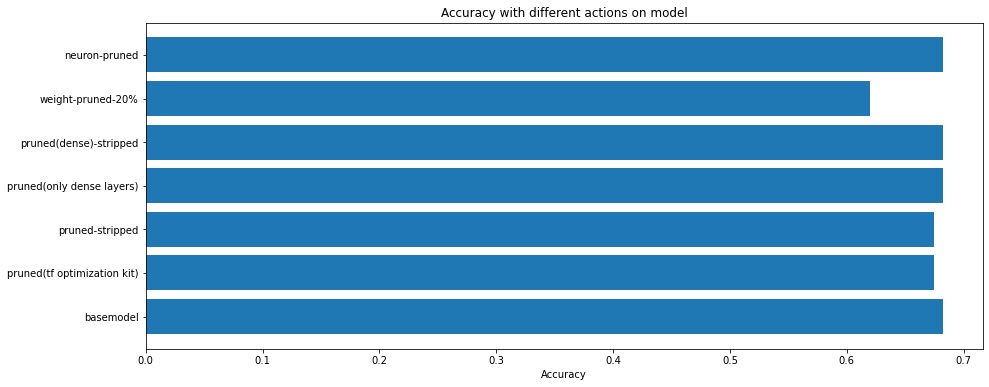

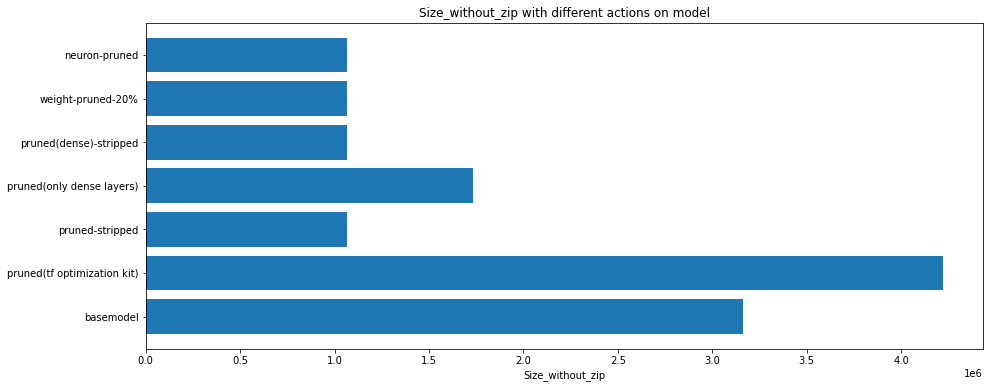

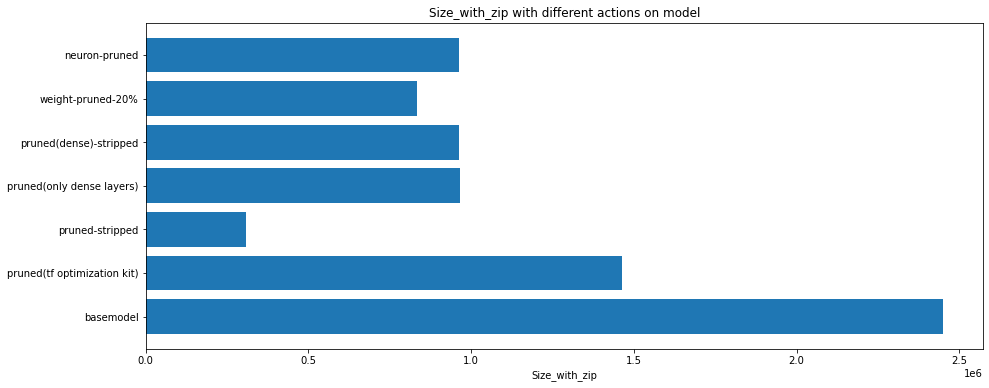

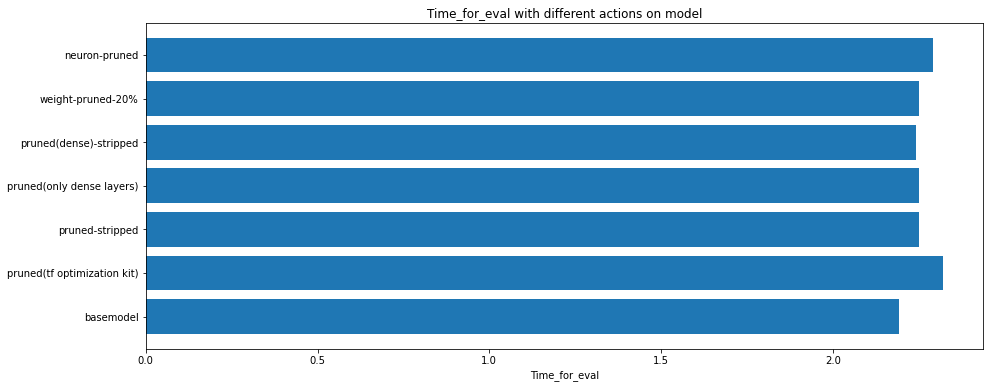

In [57]:
plotting_result('Accuracy')
plotting_result('Size_without_zip')
plotting_result('Size_with_zip')
plotting_result('Time_for_eval')